In [7]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from mylib.envs.blackjack import BlackjackEnv

from mylib import plotting

matplotlib.style.use('ggplot')

In [8]:
env = BlackjackEnv()

In [9]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        policy = np.ones(nA)*(epsilon/nA)
        astar = np.argmax(Q[observation])
        policy[astar] += 1 - epsilon
        return policy 
        # Implement this!
    return policy_fn

In [17]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    # Implement this!
    for i_ep in range(num_episodes):
        #time stemp per 1000 eps
        if i_ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_ep, num_episodes), end="")
            sys.stdout.flush()
        #generate a new episode
        episode = [] 
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state
        #value update
        sa_set = set()
        for k in range(len(episode)):
            sa_pair = (tuple(episode[k][0]), episode[k][1])
            if sa_pair in sa_set: #check if s,a is first visited
                continue
            else:
                sa_set.add(sa_pair)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[k:])])
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1
            Q[sa_pair[0]][sa_pair[1]] = returns_sum[sa_pair]/returns_count[sa_pair]
            
    return Q, policy

In [18]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

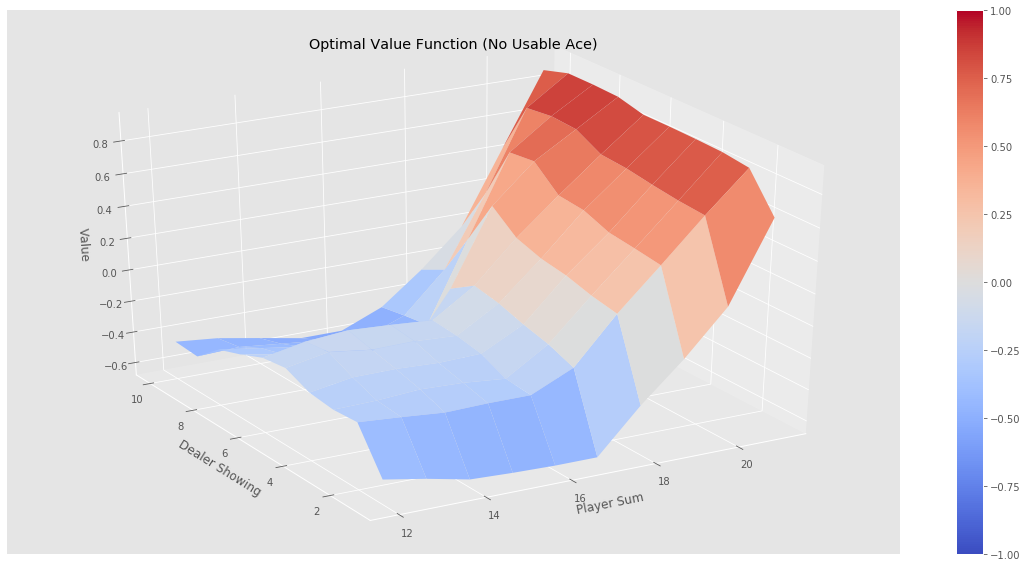

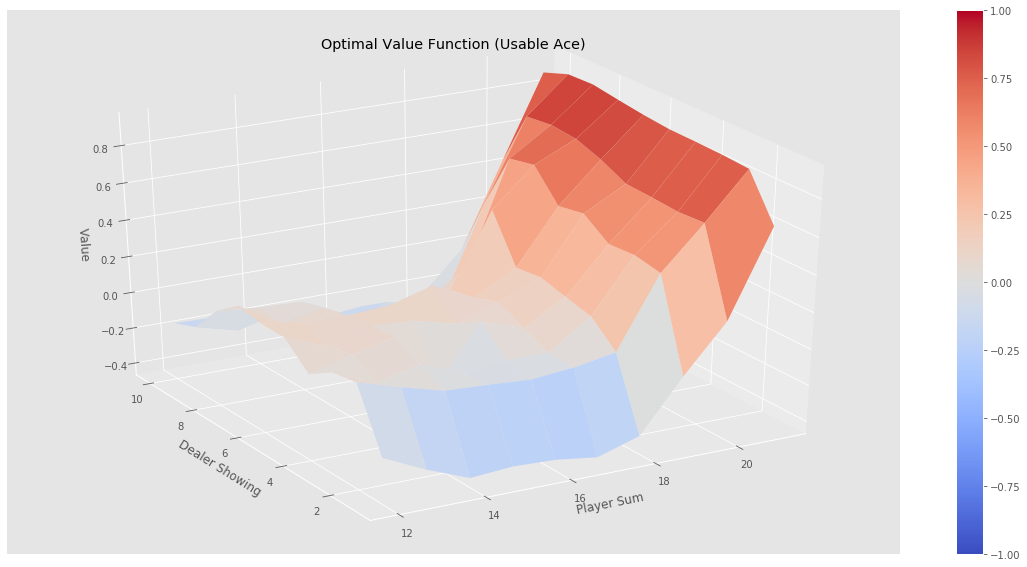

In [19]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")